<a href="https://colab.research.google.com/github/nourhan-zidan/QoE-Prediction-for-Telecom/blob/main/QoE_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Quality of Experience Prediction for HTTP Youtube Traffic on Orange Mobile Network**
This notebook develops a machine learning model to predict users’ Quality of Experience (QoE) for HTTP YouTube traffic on mobile networks, using Orange’s QoS measurement data [Poqemon-QoE-Dataset] and experimental results collected on the Orange network.

Dataset can be found at: https://github.com/Lamyne/Poqemon-QoE-Dataset

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [2]:
#Loading Dataset from my Github Repo

# Define the file path
file_path = "https://raw.githubusercontent.com/nourhan-zidan/QoE-Prediction-for-Telecom/main/pokemon.csv"

# Load the dataset
df = pd.read_csv(file_path, sep=',')

df.head()

,id,user_id,QoA_VLCresolution,QoA_VLCbitrate,QoA_VLCframerate,QoA_VLCdropped,QoA_VLCaudiorate,QoA_VLCaudioloss,QoA_BUFFERINGcount,QoA_BUFFERINGtime,...,QoD_os-version,QoD_api-level,QoU_sex,QoU_age,QoU_Ustedy,QoF_begin,QoF_shift,QoF_audio,QoF_video,MOS
0,590,71,360,528.39294,24.950000,0,43.800000,0,2,683,...,4.1.1(122573.16),16,1,20,5,3,5,3,4,3
1,428,46,360,402.64664,30.066667,0,44.200000,0,2,690,...,4.4.2(I9195XXUCNK1),19,1,25,5,4,5,5,5,5
2,406,44,360,735.84070,24.200000,0,44.183333,0,2,840,...,4.1.2(I9300XXELL4),16,1,22,5,3,5,4,4,4
3,1256,133,240,529.48830,24.116667,9,43.850000,0,2,868,...,4.4.4(suv3Rw),19,1,31,5,4,5,5,5,5
4,244,22,360,736.00085,24.066667,0,43.850000,0,2,869,...,4.1.2(I9300XXELL4),16,0,26,5,5,5,4,5,5


In [3]:
#Checking each class's count and percentage
counts = df['MOS'].value_counts()
perc = df['MOS'].value_counts(normalize=True) * 100

result = pd.concat([counts, perc], axis=1)
result.columns = ['count', 'percentage']

result

,count,percentage
MOS,,
4,784,50.810110
5,302,19.572262
3,246,15.942968
2,118,7.647440
1,93,6.027220


# **Preprocessing**

In [4]:
#Dropping NA rows
initial_rows = len(df)
df = df.dropna()
dropped_rows = initial_rows - len(df)
dropped_rows

0

In [5]:
df['QoU_Ustedy'].value_counts(normalize=True)

#Will drop study level since most of the data (92%) are the same

,proportion
QoU_Ustedy,
5,0.923526
4,0.052495
2,0.017498
3,0.006481


In [6]:
#Dropping unneaded features [id,user_id]
df = df.drop(columns=['id', 'user_id'])
df.head()

,QoA_VLCresolution,QoA_VLCbitrate,QoA_VLCframerate,QoA_VLCdropped,QoA_VLCaudiorate,QoA_VLCaudioloss,QoA_BUFFERINGcount,QoA_BUFFERINGtime,QoS_type,QoS_operator,...,QoD_os-version,QoD_api-level,QoU_sex,QoU_age,QoU_Ustedy,QoF_begin,QoF_shift,QoF_audio,QoF_video,MOS
0,360,528.39294,24.950000,0,43.800000,0,2,683,4,2,...,4.1.1(122573.16),16,1,20,5,3,5,3,4,3
1,360,402.64664,30.066667,0,44.200000,0,2,690,5,4,...,4.4.2(I9195XXUCNK1),19,1,25,5,4,5,5,5,5
2,360,735.84070,24.200000,0,44.183333,0,2,840,2,2,...,4.1.2(I9300XXELL4),16,1,22,5,3,5,4,4,4
3,240,529.48830,24.116667,9,43.850000,0,2,868,2,2,...,4.4.4(suv3Rw),19,1,31,5,4,5,5,5,5
4,360,736.00085,24.066667,0,43.850000,0,2,869,4,4,...,4.1.2(I9300XXELL4),16,0,26,5,5,5,4,5,5


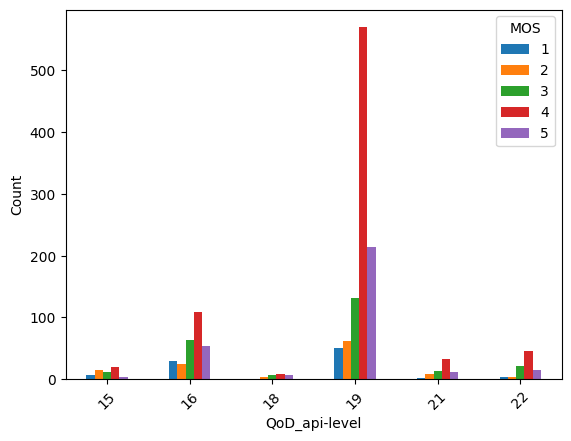

In [7]:
# Create contingency table between the categorical columns like [QoD_api-level] and plot grouped bar to visualize dependencies
import seaborn as sns

ct = pd.crosstab(df["QoD_api-level"], df["MOS"])
ct.plot(kind="bar")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [8]:
#Doing a chi-square test to assess the p-value. Very low values like this one mean there's dependency
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(ct)
print("p-value:", p)

p-value: 9.235992662425775e-12


Very similar output was seen with columns QoD_model and QoD_os-version.
Since the p-value is too small, then there's dependency between the variable and MOS.

**One-Hot Encoding to Categorical Columns**

In [9]:
df_encoded = pd.get_dummies(df, columns=["QoD_model","QoD_os-version"], drop_first=False, dtype= int)
df_encoded.head()

,QoA_VLCresolution,QoA_VLCbitrate,QoA_VLCframerate,QoA_VLCdropped,QoA_VLCaudiorate,QoA_VLCaudioloss,QoA_BUFFERINGcount,QoA_BUFFERINGtime,QoS_type,QoS_operator,...,QoD_os-version_4.4.2(I9195XXUCNK1),QoD_os-version_4.4.2(I9195XXUCNK4),QoD_os-version_4.4.2(N9005XXUGNI4),QoD_os-version_4.4.4(suv3Rw),QoD_os-version_5.0(G900FXXU1BOC2),QoD_os-version_5.0(G900FXXU1BOC7),QoD_os-version_5.0.1(1602158),QoD_os-version_5.0.1(457188.4),QoD_os-version_5.1.1(456c49d1b2),QoD_os-version_5.1.1(478106bf5f)
0,360,528.39294,24.950000,0,43.800000,0,2,683,4,2,...,0,0,0,0,0,0,0,0,0,0
1,360,402.64664,30.066667,0,44.200000,0,2,690,5,4,...,1,0,0,0,0,0,0,0,0,0
2,360,735.84070,24.200000,0,44.183333,0,2,840,2,2,...,0,0,0,0,0,0,0,0,0,0
3,240,529.48830,24.116667,9,43.850000,0,2,868,2,2,...,0,0,0,1,0,0,0,0,0,0
4,360,736.00085,24.066667,0,43.850000,0,2,869,4,4,...,0,0,0,0,0,0,0,0,0,0


**Studying Correlations between features and target 'MOS' Mean Opinion Scores**

In [10]:
corr = df_encoded.corr(numeric_only=True)          # full matrix
corr_with_MOS = corr["MOS"].abs()             # absolute correlation with target
print(corr_with_MOS.sort_values(ascending=False))

MOS                                      1.000000
QoF_audio                                0.840735
QoF_video                                0.689358
QoF_shift                                0.634058
QoF_begin                                0.591324
QoA_VLCframerate                         0.544164
QoA_BUFFERINGtime                        0.482378
QoA_BUFFERINGcount                       0.411176
QoA_VLCaudiorate                         0.353631
QoA_VLCaudioloss                         0.323338
QoA_VLCdropped                           0.237135
QoS_type                                 0.146741
QoD_model_ARCHOS 101G9                   0.134531
QoD_os-version_4.0.4(20130118.175432)    0.134531
QoD_api-level                            0.133560
QoD_model_HTC One X+                     0.118508
QoD_os-version_4.1.1(122573.16)          0.118508
QoD_model_D5803                          0.109564
QoD_os-version_4.4.4(suv3Rw)             0.107366
QoA_VLCbitrate                           0.089671


In [11]:
threshold = 0.1
# names of features to keep (including y)
keep = corr_with_MOS[corr_with_MOS >= threshold].index
# build X with only informative features
df_encoded = df_encoded[keep]

Say that you tried with threshold 0.1 first but 0.2 gave better results

In [12]:
df_encoded.shape

(1543, 19)

# **Scaling and Building the Model**
In this section, I'll try different ML algorithms and compare between them to get the best model.

**1. Logistic Regression**

In [13]:
def MyMultinomialRegression(C=1e-9):
    return make_pipeline(
        StandardScaler(),
        LogisticRegression(multi_class="multinomial", solver="lbfgs", C=C, max_iter =2000)
    )

In [14]:
df_train, df_test = train_test_split(df_encoded,test_size=0.2, random_state=1)

X_train = df_train.drop(columns=["MOS"])
X_test = df_test.drop(columns=["MOS"])
y_train = df_train['MOS']
y_test = df_test['MOS']

model = MyMultinomialRegression(C=1)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, max_iter=2000,
                                    multi_class='multinomial'))])

In [15]:
y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7702265372168284

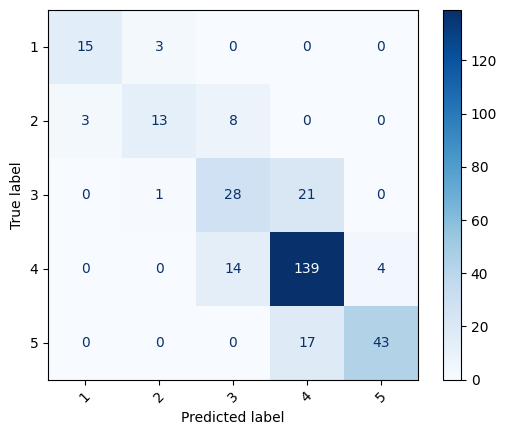

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)  # or your own labels
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

**Treating Class Imbalance using SMOTE**

In [17]:
counts = y_train.value_counts()
counts

,count
MOS,
4,627
5,242
3,196
2,94
1,75


In [18]:
#Let's try to treat the problem of class imbalance using SMOTE and view results
smote = SMOTE()

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
pd.value_counts(y_train_balanced)

/tmp/ipython-input-3865555585.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_train_balanced)


,count
MOS,
1,627
5,627
4,627
3,627
2,627


In [19]:
model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.7411003236245954

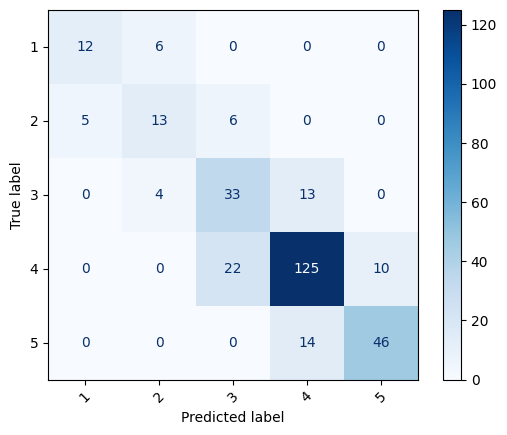

In [20]:
#Now we check the confusion matrix again
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)  # or your own labels
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

**Grid Search**

In [21]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=5)

parameters_to_test = [{ 'logisticregression__C': [1e-9, 1e-3, 0.01, 0.1, 1, 10, 100, 1000, 10000] }]

grid = GridSearchCV(MyMultinomialRegression(), parameters_to_test, cv=k_fold, scoring='f1_macro')



In [22]:
grid.fit(X_train_balanced, y_train_balanced)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(C=1e-09,
                                                           max_iter=2000,
                                                           multi_class='multinomial'))]),
             param_grid=[{'logisticregression__C': [1e-09, 0.001, 0.01, 0.1, 1,
                                                    10, 100, 1000, 10000]}],
             scoring='f1_macro')

In [23]:
print("The best regularization weigth is ", grid.best_params_)

The best regularization weigth is  {'logisticregression__C': 100}


In [24]:
model = grid.best_estimator_
model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.71      0.67      0.69        18
           2       0.57      0.54      0.55        24
           3       0.52      0.62      0.56        50
           4       0.81      0.79      0.80       157
           5       0.82      0.77      0.79        60

    accuracy                           0.73       309
   macro avg       0.68      0.68      0.68       309
weighted avg       0.74      0.73      0.73       309




**2. Random Forests**

In [39]:
model = RandomForestClassifier(n_estimators=100,
                      criterion='gini',
                      max_leaf_nodes=16, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'sqrt' # auto means=sqrt(n_features)
                      )

model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(max_leaf_nodes=16, n_jobs=-1, random_state=5)

In [40]:
y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7702265372168284

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.89      0.86        18
           2       0.72      0.75      0.73        24
           3       0.58      0.64      0.61        50
           4       0.82      0.80      0.81       157
           5       0.81      0.78      0.80        60

    accuracy                           0.77       309
   macro avg       0.76      0.77      0.76       309
weighted avg       0.77      0.77      0.77       309



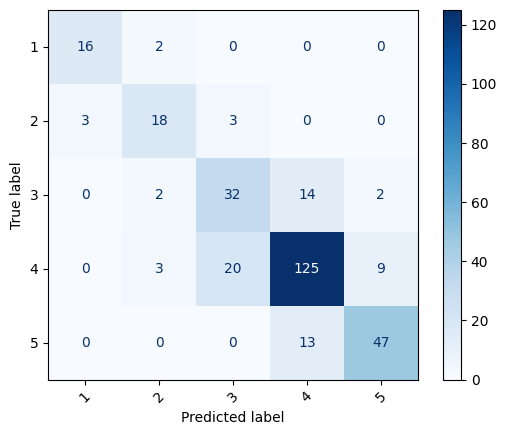

In [42]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)  # or your own labels
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

**Grid Search**

In [28]:
 rf = RandomForestClassifier(
    random_state=5,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [100],
    "max_depth": [None, 10, 20],
    "max_leaf_nodes": [16, 32, 64],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt"],
    "criterion": ["gini"]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",      # or another metric
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_balanced, y_train_balanced)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 64, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best CV score: 0.8564593301435408


In [29]:
best_model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.89      0.86        18
           2       0.72      0.75      0.73        24
           3       0.58      0.64      0.61        50
           4       0.82      0.80      0.81       157
           5       0.81      0.78      0.80        60

    accuracy                           0.77       309
   macro avg       0.76      0.77      0.76       309
weighted avg       0.77      0.77      0.77       309



**3. XGBoost**

In [30]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",  # "binary:logistic" for binary classification
    eval_metric="mlogloss",      # "logloss" for binary
    tree_method="hist",
    random_state=42
)


In [31]:
classes = np.unique(y_train_balanced)
print("Original classes:", classes)

# map to 0..K-1
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_balanced)
y_test_enc = le.transform(y_test)
print(np.unique(y_train_enc))

Original classes: [1 2 3 4 5]
[0 1 2 3 4]


In [32]:
scores = cross_val_score(xgb, X_train_balanced, y_train_enc, cv=5, scoring="accuracy")

best_acc = scores.max()
print("Best CV accuracy:", best_acc)

Best CV accuracy: 0.9409888357256778


In [33]:
xgb.fit(X_train_balanced, y_train_enc)

# evaluate on test set
y_pred = xgb.predict(X_test)
print("Test accuracy:", accuracy_score(y_test_enc, y_pred))

Test accuracy: 0.7540453074433657


In [34]:
print(classification_report(y_test_enc, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        18
           1       0.70      0.58      0.64        24
           2       0.56      0.56      0.56        50
           3       0.79      0.84      0.81       157
           4       0.86      0.73      0.79        60

    accuracy                           0.75       309
   macro avg       0.73      0.71      0.71       309
weighted avg       0.76      0.75      0.75       309



**Grid Search**

In [35]:
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5]
}

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)


In [36]:
grid_xgb.fit(X_train_balanced, y_train_enc)
print("Best params:", grid_xgb.best_params_)
print("Best CV score:", grid_xgb.best_score_)
best_xgb = grid_xgb.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 1.0}
Best CV score: 0.9125996810207336


In [37]:
best_xgb.fit(X_train_balanced, y_train_enc)

# evaluate on test set
y_pred = best_xgb.predict(X_test)
print("Test accuracy:", accuracy_score(y_test_enc, y_pred))

Test accuracy: 0.7411003236245954


In [38]:
print(classification_report(y_test_enc, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        18
           1       0.67      0.58      0.62        24
           2       0.53      0.58      0.55        50
           3       0.79      0.82      0.80       157
           4       0.86      0.72      0.78        60

    accuracy                           0.74       309
   macro avg       0.72      0.70      0.70       309
weighted avg       0.75      0.74      0.74       309

